In [1]:
import os
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.6.0


파라메터 설정

In [3]:
nb_batch = 128
img_height = 512
img_width = 512
img_size = (img_height, img_width)
img_scale_height = 224
img_scale_width = 224
dropout_rate = 0.3
learning_rate = 1e-3
nb_epochs = 100

data_dir = os.path.join("dataset")

데이터 세트 만들기

In [4]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=nb_batch)

Found 2532 files belonging to 2 classes.
Using 2026 files for training.


In [5]:
val_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=nb_batch)

Found 2532 files belonging to 2 classes.
Using 506 files for validation.


라벨 및 dataset shape 확인

In [6]:
print('Train dataset:' , train_ds)
print('Validation dataset:' , val_ds)

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

Train dataset: <BatchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Validation dataset: <BatchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
(128, 512, 512, 3)
(128,)


In [7]:
class_names = train_ds.class_names
print('class 종류:', class_names)

for image_batch, labels_batch in train_ds:
    print(labels_batch)
    break

class 종류: ['abnormal', 'normal']
tf.Tensor(
[1 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0
 1 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 1
 1 0 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0 1 0 1 1 1 0
 1 0 0 1 0 1 0 1 1 1 0 0 0 0 1 0 0], shape=(128,), dtype=int32)


데이터 시각화(이미지 확인)

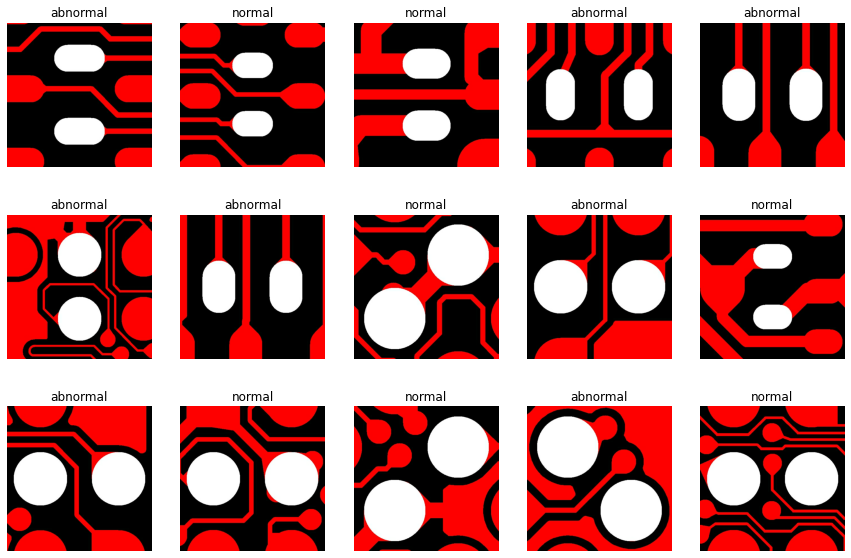

In [8]:
plt.figure(figsize=(15, 10))
train_iter = iter(train_ds)
images, labels = next(train_iter)

for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

이미지 전처리(데이터 증강)

RandomRotation : 2Pi * 10% = 36도, RandomZoom : 10%

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation_layer = keras.Sequential([
                            keras.layers.experimental.preprocessing.RandomRotation(0.1),
                            keras.layers.experimental.preprocessing.RandomZoom(0.1, fill_mode='nearest')
                        ])

def prepare(ds, shuffle=False, augment=False):
    ds = ds.cache()

    if shuffle:
        ds = ds.shuffle(512)

    # Use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation_layer(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefecting on all datasets 
    return ds.prefetch(buffer_size=AUTOTUNE)

In [10]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)

전처리 적용한 데이터 시각화

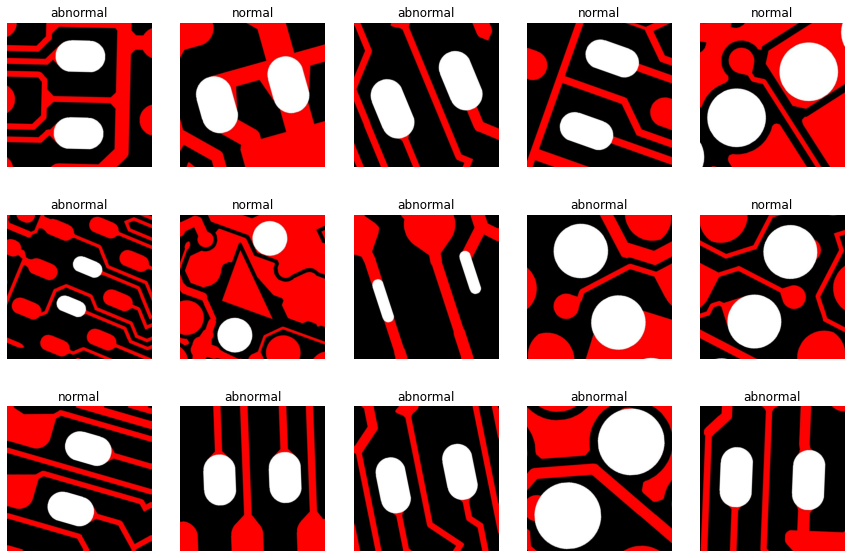

In [11]:
plt.figure(figsize=(15, 10))
train_iter = iter(train_ds)
images, labels = next(train_iter)

for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

모델 생성

In [12]:
# ResNet50V2 accurary : 95.26%
# MobileNetV2 accurary : 95.06%
# DenseNet121 : 93.68%
base_model = keras.applications.ResNet50V2(input_shape=(img_scale_height, img_scale_width, 3),
                                            weights='imagenet',
                                            include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = layers.experimental.preprocessing.Resizing(img_scale_height, img_scale_width)(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(dropout_rate)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [13]:
print("Number of layers in the base model: ", len(base_model.layers))
model.summary()

Number of layers in the base model:  190
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)   

모델 컴파일

손실함수 : 이진분류이므로 BinaryCrossentropy 적용  
옵티마이저 : Adam 적용

In [14]:
model.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate),
              metrics=['accuracy'])

콜백함수 설정

과적합(overfitting)을 방지하기 위해 10 epoch동안 성능 향상이 없으면 조기 종료

In [15]:
earlyStop = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True,
                                         monitor='val_loss')

모델 학습

In [16]:
hist = model.fit(train_ds, batch_size=nb_batch, epochs=nb_epochs,
                 verbose=1, validation_data=val_ds,
                 callbacks=[earlyStop])

Epoch 1/100
16/16 [==============================] - 21s 660ms/step - loss: 1.1693 - accuracy: 0.5237 - val_loss: 0.6352 - val_accuracy: 0.6443
Epoch 2/100
16/16 [==============================] - 11s 354ms/step - loss: 0.6690 - accuracy: 0.6160 - val_loss: 0.6201 - val_accuracy: 0.6581
Epoch 3/100
16/16 [==============================] - 11s 396ms/step - loss: 0.6062 - accuracy: 0.6634 - val_loss: 0.6014 - val_accuracy: 0.6700
Epoch 4/100
16/16 [==============================] - 11s 418ms/step - loss: 0.5765 - accuracy: 0.6915 - val_loss: 0.6051 - val_accuracy: 0.6680
Epoch 5/100
16/16 [==============================] - 11s 354ms/step - loss: 0.5829 - accuracy: 0.6811 - val_loss: 0.5858 - val_accuracy: 0.6759
Epoch 6/100
16/16 [==============================] - 11s 371ms/step - loss: 0.5573 - accuracy: 0.7024 - val_loss: 0.5746 - val_accuracy: 0.6976
Epoch 7/100
16/16 [==============================] - 11s 354ms/step - loss: 0.5460 - accuracy: 0.7231 - val_loss: 0.5827 - val_accuracy:

학습 이력 확인

4/4 - 1s - loss: 0.4981 - accuracy: 0.7510

Test accuracy: 75.10%


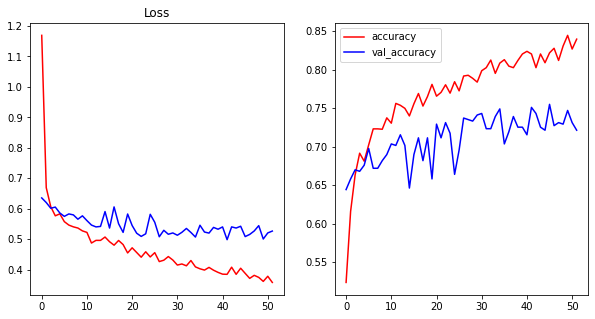

In [17]:
test_loss, test_acc = model.evaluate(val_ds, verbose=2)
print('\nTest accuracy: {:.2f}%'.format(test_acc * 100))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], 'r-', label='loss')
plt.plot(hist.history['val_loss'], 'b-', label='val_loss')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], 'r-', label='accuracy')
plt.plot(hist.history['val_accuracy'], 'b-', label='val_accuracy')
plt.legend()
plt.show()

전이학습 미세튜닝

In [18]:
# Fine-tune from this layer onwards
fine_tune_at = int(len(base_model.layers) / 2)

# Freeze all the layers before the `fine_tune_at` layer
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate / 10.0),
              metrics=['accuracy'])

model.summary()

print('Trainable params:', len(model.trainable_variables))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0     

In [19]:
pre_train_epochs = hist.epoch[-1] + 1
fine_tune_epochs = 50
total_epochs = pre_train_epochs + fine_tune_epochs

hist_fine = model.fit(train_ds, batch_size=nb_batch, epochs=total_epochs,
                 initial_epoch=pre_train_epochs,
                 verbose=1, validation_data=val_ds,
                 callbacks=[earlyStop])

Epoch 53/102
16/16 [==============================] - 22s 745ms/step - loss: 0.9279 - accuracy: 0.5513 - val_loss: 0.6475 - val_accuracy: 0.6285
Epoch 54/102
16/16 [==============================] - 15s 601ms/step - loss: 0.6648 - accuracy: 0.5864 - val_loss: 0.6546 - val_accuracy: 0.6502
Epoch 55/102
16/16 [==============================] - 15s 596ms/step - loss: 0.6097 - accuracy: 0.6560 - val_loss: 0.6317 - val_accuracy: 0.6304
Epoch 56/102
16/16 [==============================] - 15s 596ms/step - loss: 0.6122 - accuracy: 0.6668 - val_loss: 0.5487 - val_accuracy: 0.7332
Epoch 57/102
16/16 [==============================] - 15s 595ms/step - loss: 0.4981 - accuracy: 0.7616 - val_loss: 0.4299 - val_accuracy: 0.8004
Epoch 58/102
16/16 [==============================] - 15s 594ms/step - loss: 0.3656 - accuracy: 0.8435 - val_loss: 0.3084 - val_accuracy: 0.8715
Epoch 59/102
16/16 [==============================] - 15s 598ms/step - loss: 0.2780 - accuracy: 0.8860 - val_loss: 0.2552 - val_ac

4/4 - 1s - loss: 0.1529 - accuracy: 0.9526
Test accuracy: 75.10%
Fine tune test accuracy: 95.26%


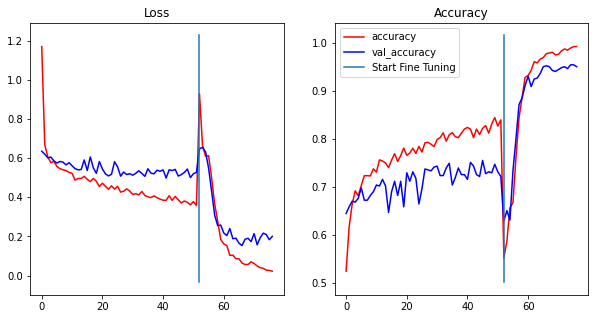

In [20]:
fine_test_loss, fine_test_acc = model.evaluate(val_ds, verbose=2)
print('Test accuracy: {:.2f}%'.format(test_acc * 100))
print('Fine tune test accuracy: {:.2f}%'.format(fine_test_acc * 100))

acc = hist.history['accuracy'] + hist_fine.history['accuracy']
val_acc = hist.history['val_accuracy'] + hist_fine.history['val_accuracy']

loss = hist.history['loss'] + hist_fine.history['loss']
val_loss = hist.history['val_loss'] + hist_fine.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss, 'r-', label='loss')
plt.plot(val_loss, 'b-', label='val_loss')
plt.plot([pre_train_epochs, pre_train_epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(acc, 'r-', label='accuracy')
plt.plot(val_acc, 'b-', label='val_accuracy')
plt.plot([pre_train_epochs, pre_train_epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.legend()
plt.title('Accuracy')
plt.show()

학습 결과 확인

In [21]:
# 학습 결과 테스트를 이미지화 함수
def plot_image(i, prediction, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.numpy().astype("uint8"))

    # predicted_label = 0 if prediction < 0.5 else 1
    predicted_label = tf.where(prediction < 0.5, 0, 1)

    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:0.2f}".format(class_names[predicted_label],
                                    prediction),
                color=color)


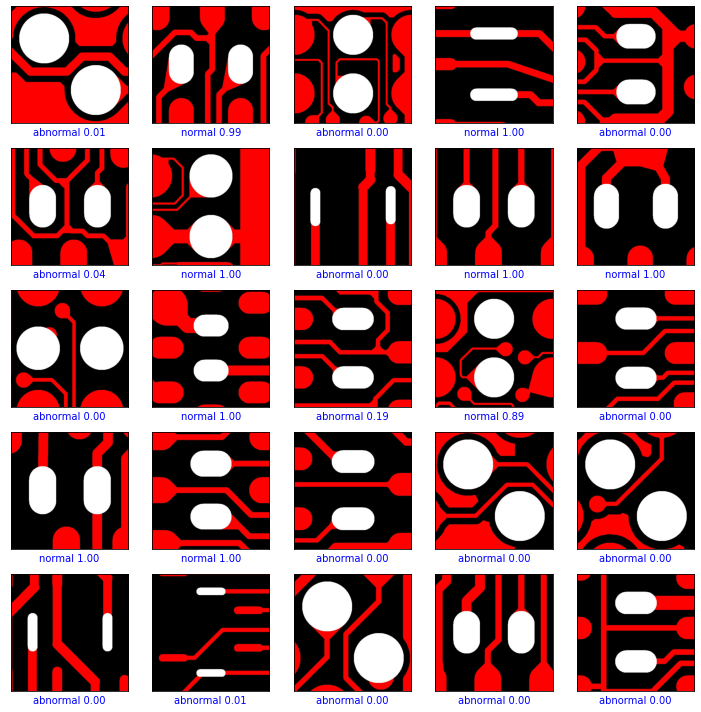

In [22]:
# 예측 결과 이미지화
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*num_cols, 2*num_rows), facecolor='white')

val_img_list, val_label_list = next(iter(val_ds.shuffle(1000)))

# Test 이미지 예측
predictions = model.predict(val_img_list)

for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    plot_image(i, predictions[i][0], val_label_list, val_img_list)
plt.tight_layout()
plt.show()

학습 완료 모델 저장

In [23]:
save_dir = os.getcwd() + "/resnet50v2"
save_ver = 1

export_path = os.path.join(save_dir, str(save_ver))

keras.models.save_model(model, export_path, overwrite=True, include_optimizer=True)

INFO:tensorflow:Assets written to: /tf/source/keras/qualcomm_pair_space_check/resnet50v2/1/assets


/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
